# NLP - Anomaly detection

## Tokenization e lematizzazione

In questa fase rimuoviamo le stopwords, numeri e caratteri speciali e poniamo tutto in minuscolo. Infine viene effettuata la lemmatizzazione usanto un modello preaddestrato (SpaCy).

In [18]:
#circa 7min di esecuzione con modello già caricato

#loading and cleaning dataset with spacy
import spacy
import pandas as pd
import regex as re

def cleaner(s):
    #removing numbers and special caracters
    s = re.sub(r'[^a-z\s]', '', s).strip()

    #removing multiple spaces
    s = " ".join(s.split()).strip()

    #some manual corrections
    s = s.replace(' accino', ' vaccino')

    #lemmatization with spacy
    doc = nlp(s)
    return " ".join([token.lemma_ for token in doc if not token.is_stop]).strip()

def remove_stopwords(s):
    doc = nlp(s)
    return " ".join([token.text for token in doc if not token.is_stop]).strip()

'''
load_stopwords_list(file_path: str) -> list
    Load stopwords from a file containing one stopword per line.
'''
def load_stopwords_list(file_path = "data/it_stopwords_kaggle.txt"):
    with open(file_path, 'r') as f:
        return f.read().splitlines()

#carichiamo il modello
nlp = spacy.load("it_core_news_md")

#load pandas dataframe
vax_df = pd.read_csv('data/posts_cleaned_it_only.csv')

#load stopwords and adding to the model
italian_stopwords = load_stopwords_list()
for stopword in italian_stopwords:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True


#selezioniamo solo la colonna clean_text
vax_df = vax_df['clean_text']

#applichiamo la funzione di pulizia
vax_df_cleaned = vax_df.apply(cleaner)
#è necessario applicare nuovamente la funzione per rimuovere le stopwords che sono state aggiunte dalla lemmatizzazione
vax_df_cleaned = vax_df_cleaned.apply(remove_stopwords)

#esportiamo il dataset pulito in formato csv 
vax_df_cleaned.to_csv('data/posts_ULTRAcleaned_it_only_spacy.csv', index=False)

## Analisi del dataset  

Semplicemente contiamo il numero di parole.

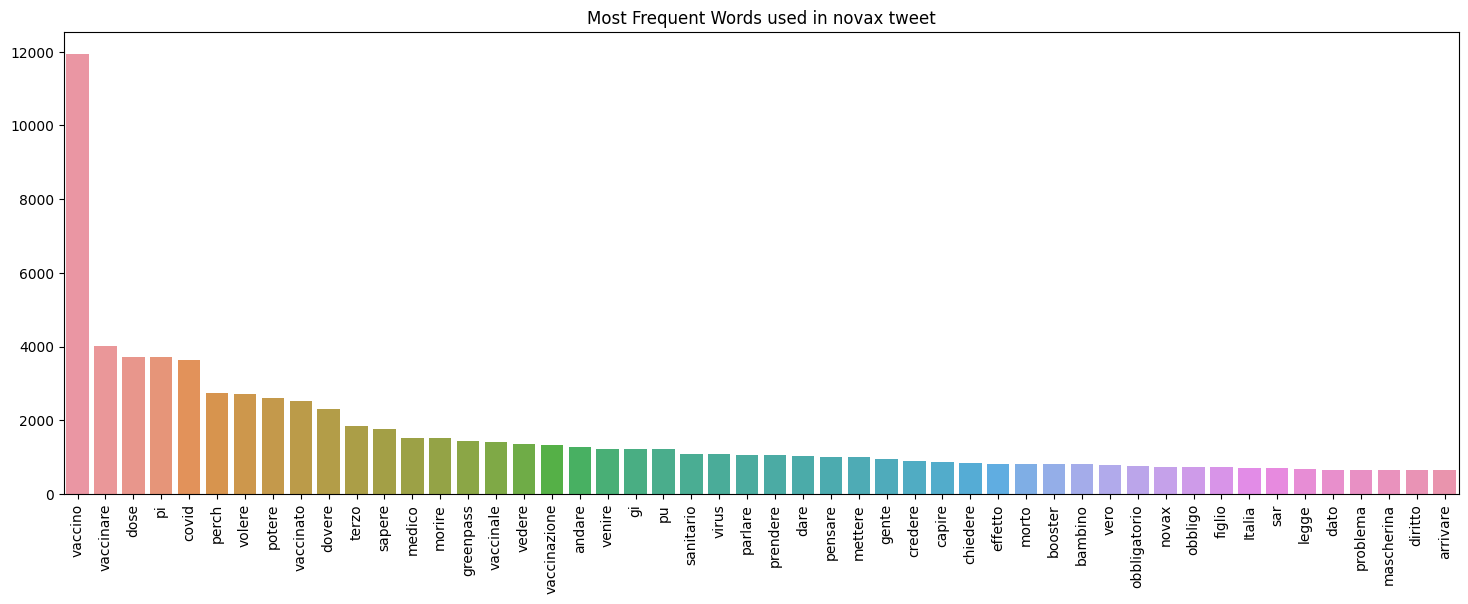

In [19]:
#analisi del dataset pulito 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

#contiamo le parole
aggregate_counter = Counter()
for row in vax_df_cleaned:
    c = Counter(row.split())
    aggregate_counter += c

common_words = [word[0] for word in aggregate_counter.most_common(50)]
common_words_counts = [word[1] for word in aggregate_counter.most_common(50)]

#disegnamo i grafici
def barplot(words, words_counts, title):
    fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=words, y=words_counts)
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()


barplot(words=common_words, words_counts=common_words_counts, title='Most Frequent Words used in novax tweet')

## Embedding  

Usiamo un modello preaddestrato (SpaCy) per creare un embedding delle parole.

In [20]:
#vettorizzazione (embedding) del dataset pulito
import spacy
import pandas as pd

#carichiamo il modello
nlp = spacy.load("it_core_news_md")

#load pandas dataframe (rimuovo le righe vuote che putroppo sono presenti)
vax_series = pd.read_csv('data/posts_ULTRAcleaned_it_only_spacy.csv')
vax_series.dropna(inplace=True)

#create a new column with the cleaned text dataframe with the vector representation of the text
vector_list = []
for x in vax_series["clean_text"]:
    vector = nlp(x).vector
    vector_list.append(vector)

#casting series to Datafram
vax_df = pd.DataFrame(vax_series)
#append vector column
vax_df['vector'] = vector_list

#flatteing (piallare) the vector column in 96 columns
vector_dim = len(vax_df['vector'][0]) #sono tutte uguali
for i in range(vector_dim):
    vax_df[f'vector_{i}'] = vax_df['vector'].apply(lambda x: x[i])

#drop the vector column
vax_df.drop(columns=['vector'], inplace=True)

#deframmentazione del dataset
vax_df = vax_df.copy()

#creiamo una lista con i nomi delle colonne numeriche
NUM_VECTOR_COLUMNS = len(vax_df.columns) -1 #96
numeric_columns_names = [f'vector_{i}' for i in range(NUM_VECTOR_COLUMNS)]

#esportiamo il dataframe pulito in formato csv 
vax_df.to_csv('data/post_it_cleaned_vectorized.csv', index=False)

/tmp/ipykernel_298/3762391201.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vax_df[f'vector_{i}'] = vax_df['vector'].apply(lambda x: x[i])
/tmp/ipykernel_298/3762391201.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vax_df[f'vector_{i}'] = vax_df['vector'].apply(lambda x: x[i])
/tmp/ipykernel_298/3762391201.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

## Unsupervised learning

Usiamo un autoencoder per creare un modello che possa riconoscere le anomalie. Prima di tutto improtiamo il dataset.

In [21]:

import pandas as pd
import numpy as np

#settings type for all vector columns 
#dtypes = {f'vector_{i}': np.float32 for i in range(NUM_VECTOR_COLUMNS)}

#load pandas dataframe (rimuovo le righe vuote che putroppo sono presenti)
vax_df = pd.read_csv('data/post_it_cleaned_vectorized.csv')
vax_df.dropna(inplace=True)


NUM_VECTOR_COLUMNS = len(vax_df.columns) -1 #96

#utlili per il processo di addestramento
input_dim = vax_df["vector_0"].shape[0]
numeric_columns_names = [f'vector_{i}' for i in range(NUM_VECTOR_COLUMNS)]
#ORA NON SERVE PIù CONVERTIRE IN ARRAY PERCHè I VALORI SONO GIA' FLOAT

### MLP regressor

Usiamo un regressore per capire se una frase è anomala o meno.

In [22]:
#Training the autoencoder
from sklearn.neural_network import MLPRegressor

#converto la lista di array numpy in un array numpy
#test = vax_df["vector"]

auto_encoder = MLPRegressor(hidden_layer_sizes=(
                                                 192,
                                                 47, 
                                                 192,
                                               ))
auto_encoder.fit(vax_df[numeric_columns_names], vax_df[numeric_columns_names])


MLPRegressor(hidden_layer_sizes=(192, 47, 192))

/home/apsev/.local/lib/python3.8/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Score: 0.7797720888370269


<Axes: >

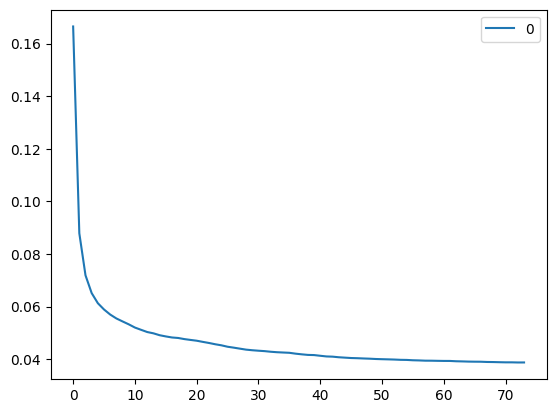

In [23]:
#Test delle performance del modello (sempre sui dati di training)
predicted_vectors = auto_encoder.predict(vax_df[numeric_columns_names])
score = auto_encoder.score(predicted_vectors, vax_df[numeric_columns_names])
print(f"Score: {score}")

pd.DataFrame(auto_encoder.loss_curve_).plot()

## Test di inferenza con frasi nuove

In [24]:
# Applicazione del modello all'anomaly detection
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean


#loading and cleaning dataset with spacy
import spacy
import pandas as pd
import regex as re

def cleaner(s):
    #removing numbers and special caracters
    s = re.sub(r'[^a-z\s]', '', s).strip()

    #removing multiple spaces
    s = " ".join(s.split()).strip()

    #some manual corrections
    s = s.replace(' accino', ' vaccino')

    #lemmatization with spacy
    doc = nlp(s)
    return " ".join([token.lemma_ for token in doc if not token.is_stop]).strip()

def remove_stopwords(s):
    doc = nlp(s)
    return " ".join([token.text for token in doc if not token.is_stop]).strip()

'''
load_stopwords_list(file_path: str) -> list
    Load stopwords from a file containing one stopword per line.
'''
def load_stopwords_list(file_path = "data/it_stopwords_kaggle.txt"):
    with open(file_path, 'r') as f:
        return f.read().splitlines()

#carichiamo il modello
nlp = spacy.load("it_core_news_md")

#load stopwords and adding to the model
italian_stopwords = load_stopwords_list()
for stopword in italian_stopwords:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True


#provo con un testo casuale
testo = "Il cane ha preso la palla"

#cleaning
testo = cleaner(testo)

#remove stopwords
testo = remove_stopwords(testo)

#vectorization
testo_vector = nlp(testo).vector

#salvo il vettore in dataframe pandas
testo_df = pd.DataFrame([testo_vector], columns=[f'vector_{i}' for i in range(NUM_VECTOR_COLUMNS)])

#prediction
vector_predicted = auto_encoder.predict(testo_df)
vector_predicted_df = pd.DataFrame(vector_predicted, columns=[f'vector_{i}' for i in range(NUM_VECTOR_COLUMNS)])

#distance
distance = [ 1 - cosine(vector_predicted[0], testo_vector), euclidean(vector_predicted[0], testo_vector) ]
print(distance)



[0.8445737612860857, 13.784868045716745]


Si nota una leggerlo abbassamento della precisione in casi di "anomalie" ma forse troppo piccolo per essere significativo.

# Proviamo con keras

https://www.kaggle.com/code/robinteuwens/anomaly-detection-with-auto-encoders 

## Configurazione modello 

Autoencoder e altri parametri

In [25]:
# data dimensions // hyperparameters 
import tensorflow as tf
import numpy as np
from datetime import datetime


input_dim = vax_df.columns.size -1

#CONFIG 
BATCH_SIZE = 256
EPOCHS = 100

# https://keras.io/layers/core/
keras_autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dense(32, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),

    tf.keras.layers.Dense(2, activation='elu'),
    
    # reconstruction / decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(32, activation='elu'),
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])


# current date and time
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

# new folder for a new run
log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(keras_autoencoder.layers)}'

# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

tensorboard = tf.keras.callbacks.TensorBoard(
    f'logs/{log_subdir}',
    update_freq='batch'
)

# callbacks argument only takes a list
cb = [early_stop, save_model, tensorboard]

# https://keras.io/api/models/model_training_apis/
keras_autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])

# print an overview of our model
keras_autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 300)               90300     
                                                                 
 dense_14 (Dense)            (None, 128)               38528     
                                                                 
 dense_15 (Dense)            (None, 32)                4128      
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 8)                 136       
                                                                 
 dense_18 (Dense)            (None, 4)                 36        
                                                                 
 dense_19 (Dense)            (None, 2)                

## Addestramento autoencoder (con Keras)  

Per non fare confusione con il modello precedente l'ho rinominato in keras_autoencoder.

In [28]:
vax_df_train = vax_df.sample(frac=0.8, random_state=0)
vax_df_val = vax_df.drop(vax_df_train.index)

history = keras_autoencoder.fit(
    vax_df_train[numeric_columns_names], vax_df_train[numeric_columns_names],
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(vax_df_val[numeric_columns_names], vax_df_val[numeric_columns_names])
)

Epoch 1/100
60/60 [==============================] - 0s 8ms/step - loss: 0.2823 - acc: 0.3487 - val_loss: 0.2794 - val_acc: 0.3449
Epoch 2/100
60/60 [==============================] - 0s 6ms/step - loss: 0.2820 - acc: 0.3480 - val_loss: 0.2806 - val_acc: 0.3572
Epoch 3/100
60/60 [==============================] - 0s 7ms/step - loss: 0.2809 - acc: 0.3546 - val_loss: 0.2786 - val_acc: 0.3545
Epoch 4/100
60/60 [==============================] - 0s 7ms/step - loss: 0.2802 - acc: 0.3534 - val_loss: 0.2783 - val_acc: 0.3566
Epoch 5/100
60/60 [==============================] - 0s 7ms/step - loss: 0.2793 - acc: 0.3544 - val_loss: 0.2771 - val_acc: 0.3608
Epoch 6/100
60/60 [==============================] - 0s 6ms/step - loss: 0.2792 - acc: 0.3566 - val_loss: 0.2785 - val_acc: 0.3640
Epoch 7/100
60/60 [==============================] - 0s 7ms/step - loss: 0.2789 - acc: 0.3525 - val_loss: 0.2778 - val_acc: 0.3616
Epoch 8/100
60/60 [==============================] - 0s 7ms/step - loss: 0.2789 - a

KeyboardInterrupt: 

In [ ]:
len(vax_df[numeric_columns_names])

19097

### Analisi della mse del dataset originale

Cerchiamo di capire come usare la MSE per capire se una frase è anomala o meno. Nello specifico guardiamo la distribuzione e cerchiamo di stabilire una soglia oltre la quale una frase è anomala.  

Notiamo che mettendo la soglia a 2 riusciamo a classificare il 90% del dataset in modo corretto. Però anche in questo caso non possiamo dire nulla di preciso sulle anomalie.

597/597 [==============================] - 1s 2ms/step


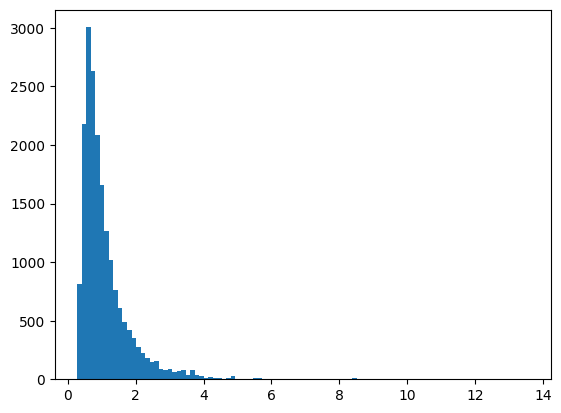

count    19097.000000
mean         1.104133
std          0.820115
min          0.278176
50%          0.863751
75%          1.294261
90%          1.969251
95%          2.565478
99%          3.948294
max         13.570157
Name: mse, dtype: float64


In [ ]:
import pandas as pd

# ANALISI errore ricostruzione nel dataset originale
recontructions = keras_autoencoder.predict(vax_df[numeric_columns_names])

mse = np.mean(np.power(vax_df[numeric_columns_names] - recontructions, 2), axis=1)

#create a dataframe with 2 columns text and mse
test = pd.DataFrame({'clean_text': vax_df["clean_text"], 'mse': mse})

#draw an histogram with mse
plt.hist(test['mse'], bins=100,  label='mse')
plt.show()

#some statistics
print(test['mse'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))

### Test inferenza con testo nuovo

Proviamo a usare il modello e calcoliamo l'errore di ricnostruzione (nelle anomalie dovrebbe essere maggiore dato che sono diverse dal dataset)

In [ ]:
# Applicazione del modello all'anomaly detection
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean


#loading and cleaning dataset with spacy
import spacy
import pandas as pd
import regex as re

def cleaner(s):
    #removing numbers and special caracters
    s = re.sub(r'[^a-z\s]', '', s).strip()

    #removing multiple spaces
    s = " ".join(s.split()).strip()

    #some manual corrections
    s = s.replace(' accino', ' vaccino')

    #lemmatization with spacy
    doc = nlp(s)
    return " ".join([token.lemma_ for token in doc if not token.is_stop]).strip()

def remove_stopwords(s):
    doc = nlp(s)
    return " ".join([token.text for token in doc if not token.is_stop]).strip()

'''
load_stopwords_list(file_path: str) -> list
    Load stopwords from a file containing one stopword per line.
'''
def load_stopwords_list(file_path = "data/it_stopwords_kaggle.txt"):
    with open(file_path, 'r') as f:
        return f.read().splitlines()

#carichiamo il modello
nlp = spacy.load("it_core_news_md")

#load stopwords and adding to the model
italian_stopwords = load_stopwords_list()
for stopword in italian_stopwords:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True


#provo con un testo casuale
testo = "i sono il bene che è sceso da dio in terra grazie alla scienza ed alla medicina possimmo salvare la vita di milioni di persone e curarci"
#testo = "i vaccini e le vaccinazioni sono dannosi"

#cleaning
testo = cleaner(testo)

#remove stopwords
testo = remove_stopwords(testo)

#vectorization
testo_vector = nlp(testo).vector

#salvo il vettore in dataframe pandas
testo_df = pd.DataFrame([testo_vector], columns=[f'vector_{i}' for i in range(NUM_VECTOR_COLUMNS)])

#prediction
vector_predicted = keras_autoencoder.predict(testo_df)
vector_predicted_df = pd.DataFrame(vector_predicted, columns=[f'vector_{i}' for i in range(NUM_VECTOR_COLUMNS)])

#distance
#distance = [ 1 - cosine(vector_predicted[0], testo_vector), euclidean(vector_predicted[0], testo_vector) ]

#reconstruction error with mse
distance = np.mean(np.power(testo_df - vector_predicted_df, 2), axis=1)

print(distance)

1/1 [==============================] - 0s 30ms/step
0    0.781829
dtype: float32


# Noise Injection 

In [ ]:
def add_noise(x, noise_factor=0.2):
    x = x + np.random.randn(*x.shape) * noise_factor
    x = x.clip(0., 1.)
    return x

X_train_noisy = add_noise(vax_df[numeric_columns_names])

history = keras_autoencoder.fit(
    X_train_noisy, vax_df[numeric_columns_names],
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    #validation_data=(X_validate_transformed, X_validate_transformed)
);


Epoch 1/100
75/75 [==============================] - 2s 5ms/step - loss: 2.5195 - acc: 0.0540
Epoch 2/100
75/75 [==============================] - 0s 4ms/step - loss: 1.4471 - acc: 0.2511
Epoch 3/100
75/75 [==============================] - 0s 4ms/step - loss: 1.3974 - acc: 0.2531
Epoch 4/100
75/75 [==============================] - 0s 4ms/step - loss: 1.3803 - acc: 0.2572
Epoch 5/100
75/75 [==============================] - 0s 4ms/step - loss: 1.3555 - acc: 0.2669
Epoch 6/100
75/75 [==============================] - 0s 4ms/step - loss: 1.3097 - acc: 0.2723
Epoch 7/100
75/75 [==============================] - 0s 4ms/step - loss: 1.2720 - acc: 0.2795
Epoch 8/100
75/75 [==============================] - 0s 4ms/step - loss: 1.2616 - acc: 0.2882
Epoch 9/100
75/75 [==============================] - 0s 4ms/step - loss: 1.2588 - acc: 0.2894
Epoch 10/100
75/75 [==============================] - 0s 4ms/step - loss: 1.2576 - acc: 0.2865
Epoch 11/100
75/75 [==============================] - 0s 4m

597/597 [==============================] - 1s 2ms/step


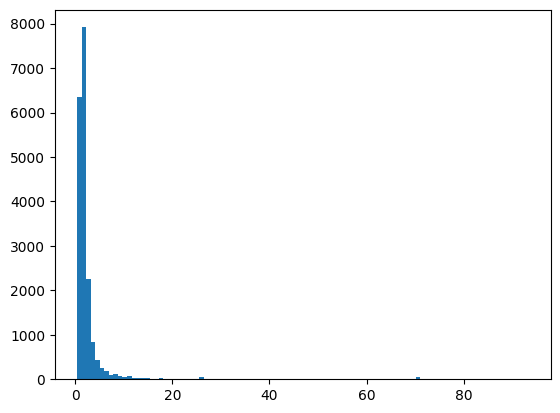

count    19097.000000
mean         2.697557
std          5.590283
min          0.430357
50%          1.642206
75%          2.303154
90%          3.901339
95%          6.423464
99%         26.327825
max         93.320524
Name: mse, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# ANALISI errore ricostruzione nel dataset originale
recontructions = keras_autoencoder.predict(vax_df[numeric_columns_names])

mse = np.mean(np.power(vax_df[numeric_columns_names] - recontructions, 2), axis=1)

#create a dataframe with 2 columns text and mse
test = pd.DataFrame({'clean_text': vax_df["clean_text"], 'mse': mse})

#draw an histogram with mse
plt.hist(test['mse'], bins=100,  label='mse')
plt.show()

#some statistics
print(test['mse'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))

In [ ]:
# Applicazione del modello all'anomaly detection
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean

NUM_VECTOR_COLUMNS = len(vax_df.columns) -1 #96
#loading and cleaning dataset with spacy
import spacy
import pandas as pd
import regex as re

def cleaner(s):
    #removing numbers and special caracters
    s = re.sub(r'[^a-z\s]', '', s).strip()

    #removing multiple spaces
    s = " ".join(s.split()).strip()

    #some manual corrections
    s = s.replace(' accino', ' vaccino')

    #lemmatization with spacy
    doc = nlp(s)
    return " ".join([token.lemma_ for token in doc if not token.is_stop]).strip()

def remove_stopwords(s):
    doc = nlp(s)
    return " ".join([token.text for token in doc if not token.is_stop]).strip()

'''
load_stopwords_list(file_path: str) -> list
    Load stopwords from a file containing one stopword per line.
'''
def load_stopwords_list(file_path = "data/it_stopwords_kaggle.txt"):
    with open(file_path, 'r') as f:
        return f.read().splitlines()

#carichiamo il modello
nlp = spacy.load("it_core_news_md")

#load stopwords and adding to the model
italian_stopwords = load_stopwords_list()
for stopword in italian_stopwords:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True


#provo con un testo casuale
testo = "i pony sono gli animali più belli del mondo"
#testo = "i vaccini e le vaccinazioni sono dannosi"

#cleaning
testo = cleaner(testo)

#remove stopwords
testo = remove_stopwords(testo)

#vectorization
testo_vector = nlp(testo).vector

#salvo il vettore in dataframe pandas
testo_df = pd.DataFrame([testo_vector], columns=[f'vector_{i}' for i in range(NUM_VECTOR_COLUMNS)])

#prediction
vector_predicted = keras_autoencoder.predict(testo_df)
vector_predicted_df = pd.DataFrame(vector_predicted, columns=[f'vector_{i}' for i in range(NUM_VECTOR_COLUMNS)])

#distance
#distance = [ 1 - cosine(vector_predicted[0], testo_vector), euclidean(vector_predicted[0], testo_vector) ]

#reconstruction error with mse
distance = np.mean(np.power(testo_df - vector_predicted_df, 2), axis=1)

print(distance)

1/1 [==============================] - 0s 24ms/step
0    2.56914
dtype: float32


### Cosine distance

Usiamo al posto della MSE la consine distance per trovare le anomalie

597/597 [==============================] - 2s 3ms/step


/home/lorenzo2004/.local/lib/python3.10/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/home/lorenzo2004/.local/lib/python3.10/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/home/lorenzo2004/.local/lib/python3.10/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/home/lorenzo2004/.local/lib/python3.10/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/home/lorenzo2004/.local/lib/python3.10/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/home/lorenzo2004/.local/lib/python3.10/site-packages/scipy/spatial/distance.py:620: Runti

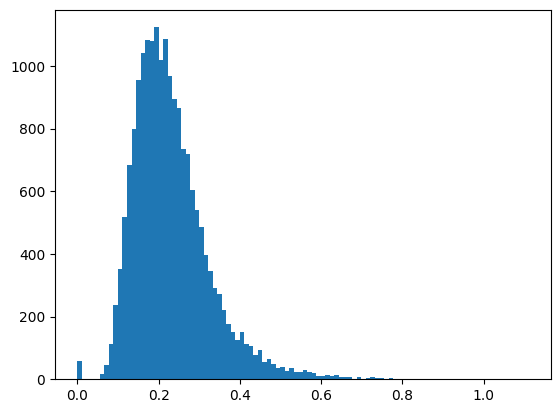

count    19097.000000
mean         0.231570
std          0.095459
min          0.000000
50%          0.215132
75%          0.276391
90%          0.349349
95%          0.410052
99%          0.558338
max          1.109989
Name: cosine, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# ANALISI errore ricostruzione nel dataset originale
recontructions = keras_autoencoder.predict(vax_df[numeric_columns_names])

cosine_list = []
for i in range(len(vax_df[numeric_columns_names])):
    cosine_list.append( cosine(vax_df[numeric_columns_names].iloc[i], recontructions[i]) )


#create a dataframe with 2 columns text and mse
test = pd.DataFrame({'clean_text': vax_df["clean_text"], 'cosine': cosine_list})

#draw an histogram with mse
plt.hist(test['cosine'], bins=100,  label='mse')
plt.show()

#some statistics
print(test['cosine'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))

In [ ]:
# Applicazione del modello all'anomaly detection
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean

NUM_VECTOR_COLUMNS = len(vax_df.columns) -1 #96
#loading and cleaning dataset with spacy
import spacy
import pandas as pd
import regex as re

def cleaner(s):
    #removing numbers and special caracters
    s = re.sub(r'[^a-z\s]', '', s).strip()

    #removing multiple spaces
    s = " ".join(s.split()).strip()

    #some manual corrections
    s = s.replace(' accino', ' vaccino')

    #lemmatization with spacy
    doc = nlp(s)
    return " ".join([token.lemma_ for token in doc if not token.is_stop]).strip()

def remove_stopwords(s):
    doc = nlp(s)
    return " ".join([token.text for token in doc if not token.is_stop]).strip()

'''
load_stopwords_list(file_path: str) -> list
    Load stopwords from a file containing one stopword per line.
'''
def load_stopwords_list(file_path = "data/it_stopwords_kaggle.txt"):
    with open(file_path, 'r') as f:
        return f.read().splitlines()

#carichiamo il modello
nlp = spacy.load("it_core_news_md")

#load stopwords and adding to the model
italian_stopwords = load_stopwords_list()
for stopword in italian_stopwords:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True


#provo con un testo casuale
testo = "i pony sono gli animali più belli del mondo"
#testo = "i vaccini e le vaccinazioni sono dannosi"

#cleaning
testo = cleaner(testo)

#remove stopwords
testo = remove_stopwords(testo)

#vectorization
testo_vector = nlp(testo).vector

#salvo il vettore in dataframe pandas
testo_df = pd.DataFrame([testo_vector], columns=[f'vector_{i}' for i in range(NUM_VECTOR_COLUMNS)])

#prediction
vector_predicted = keras_autoencoder.predict(testo_df)
vector_predicted_df = pd.DataFrame(vector_predicted, columns=[f'vector_{i}' for i in range(NUM_VECTOR_COLUMNS)])

#distance
distance_mse = [ 1 - cosine(vector_predicted[0], testo_vector), euclidean(vector_predicted[0], testo_vector) ]

#reconstruction error with cosine
distance = np.mean(cosine(testo_df.iloc[0] , vector_predicted_df.iloc[0]))

print(distance, distance_mse)

1/1 [==============================] - 0s 28ms/step
0.32814687490463257
